# Analyzing and tuning a resonator
We will use here the `advanced` EPR method to run the simulation and analysi, which directly controls renderers and external packages. Please refer to the tutorial notebook 4.2 to follow the `suggested` flow to run the analysis.

### Resonator design
1. Prepare the single transmon qubit layout in qiskit-metal. <br>

### Resonator analysis using EPR method
1. Set-up and run a finite element simulate to extract the eigenmode. <br>
1. Display EM fields to inspect quality of the setup. <br>
1. Calculate EPR of substrate.  <br>

## Prerequisite
You need to have a working local installation of Ansys.<br>
Also you will need the following directives and inports.

In [1]:
%load_ext autoreload
%autoreload 2

import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings
import pyEPR as epr

# 1. Create the Resonator design

Fix the design dimensions that you intend to reflect in the design rendering. <br>
Note that the design size extends from the origin into the first quadrant.

In [2]:
design = designs.DesignPlanar({}, True)
design.chips.main.size['size_x'] = '2mm'
design.chips.main.size['size_y'] = '2mm'

gui = MetalGUI(design)

Create a readout resonator. Here, we define one end of the resonator as a short and the other end as an open. 

In [3]:
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround

design.delete_all_components()

otg = OpenToGround(design, 'open_to_ground', options=dict(pos_x='1.25mm',  pos_y='0um', orientation='0'))
stg = ShortToGround(design, 'short_to_ground', options=dict(pos_x='-1.25mm',  pos_y='0um', orientation='180'))
rt_meander = RouteMeander(design, 'readout',  Dict(
        total_length='6 mm',
        hfss_wire_bonds = True,
        fillet='90 um',
        lead = dict(start_straight='100um'),
        pin_inputs=Dict(
            start_pin=Dict(component='short_to_ground', pin='short'),
            end_pin=Dict(component='open_to_ground', pin='open')), ))

gui.rebuild()
gui.autoscale()

# 2. Analyze the resonator using the Eigenmode-EPR method

In this section we will use a semi-manual (advanced) analysis flow. Please refer to tutorial 4.2 for the `suggested` method. As illustrated, the methods are equivalent, but the advanced method allows you to directly override some renderer-specific settings.

### Finite Element Eigenmode Analysis

#### Setup

Select the analysis you intend to run from the `qiskit_metal.analyses` collection.<br>
Select the design to analyze and the tool to use for any external simulation.

In [4]:
from qiskit_metal.analyses.quantization import EPRanalysis
eig_res = EPRanalysis(design, "hfss")

For the Eigenmode simulation portion, you can either:
1. Use the `eig_res` user-friendly methods (see tutorial 4.2)
2. Control directly the simulation tool from the tool's GUI (outside metal - see specific vendor instructions)
3. Use the renderer methods
In this section we show the advanced method (method 3).

The renderer can be reached from the analysis class. Let's give it a shorter alias.

In [5]:
hfss = eig_res.sim.renderer

Now we connect to the tool using the unified command.

In [6]:
hfss.start()

INFO 09:20AM [connect_project]: Connecting to Ansys Desktop API...
INFO 09:20AM [load_ansys_project]: 	Opened Ansys App
INFO 09:20AM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 09:20AM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Ansoft/
	Project:   Project23
INFO 09:20AM [connect_design]: No active design found (or error getting active design).
INFO 09:20AM [connect]: 	 Connected to project "Project23". No design detected


True

The previous command is supposed to open ansys (if closed), create a new project and finally connect this notebook to it.

If for any reason the previous cell failed, please try the manual path described in the next three cells:
1. uncomment and execute only **one** of the lines in the first cell.
1. uncomment and execute the second cell.
1. uncomment and execute only **one** of the lines in the third cell.

In [7]:
# hfss.open_ansys()   # this opens Ansys 2021 R2 if present
# hfss.open_ansys(path_var='ANSYSEM_ROOT211')
# hfss.open_ansys(path='C:\Program Files\AnsysEM\AnsysEM21.1\Win64')
# hfss.open_ansys(path='../../../Program Files/AnsysEM/AnsysEM21.1/Win64')

In [8]:
# hfss.new_ansys_project()

In [9]:
# hfss.connect_ansys()
# hfss.connect_ansys('C:\\project_path\\', 'Project1')  # will open a saved project before linking the Jupyter session

#### Execute simulation and verify convergence

Create and activate an eigenmode design called "Readout".

In [10]:
hfss.activate_ansys_design("Readout", 'eigenmode')  # use new_ansys_design() to force creation of a blank design

09:20AM 02s WARNING [activate_ansys_design]: The design_name=Readout was not in active project.  Designs in active project are: 
[].  A new design will be added to the project.  
INFO 09:20AM [connect_design]: 	Opened active design
	Design:    Readout [Solution type: Eigenmode]
WARNING 09:20AM [connect_setup]: 	No design setup detected.
WARNING 09:20AM [connect_setup]: 	Creating eigenmode default setup.
INFO 09:20AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


Render the resonator called readout in Metal, to "Readout" design in Ansys.

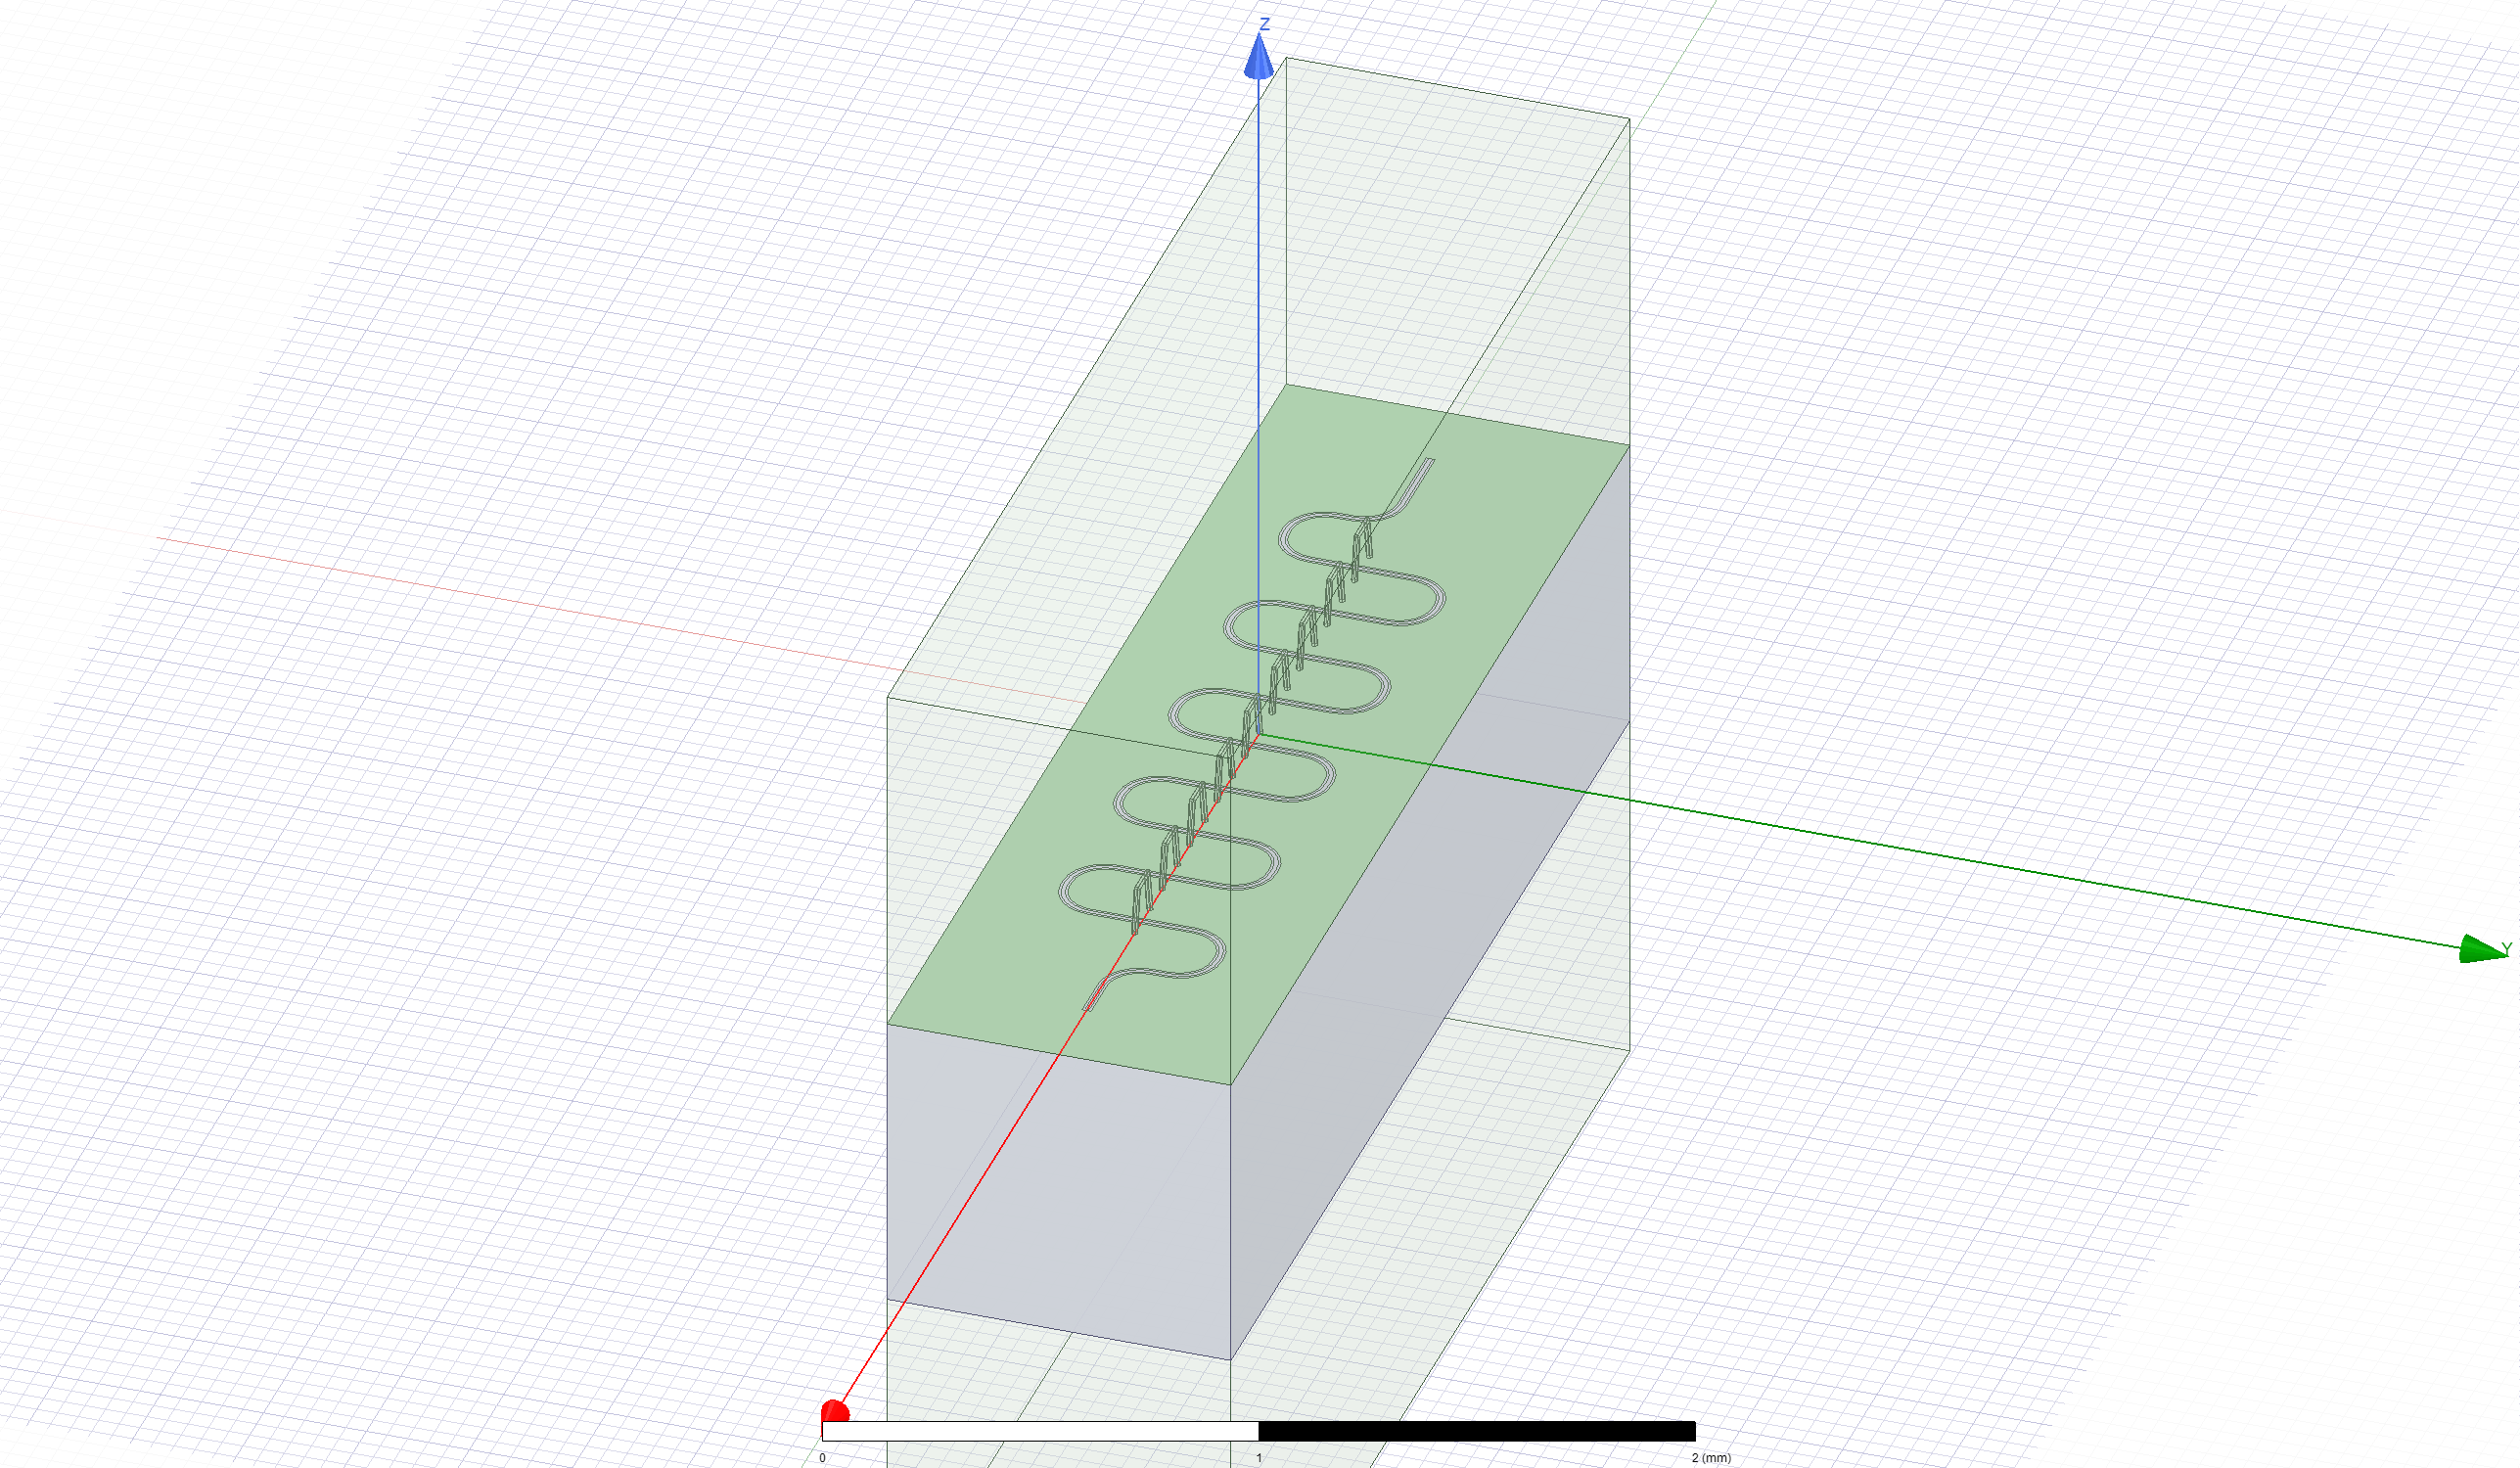

In [11]:
hfss.render_design(['short_to_ground', 'readout', 'open_to_ground'], [])
hfss.save_screenshot()

Set the convergence parameters and junction properties in the Ansys design. <br>
Then run the analysis and plot the convergence.

In [12]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 20
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

# Next 2 lines are counterinuitive, since there is no junction in this resonator.
# However, these are necessary to make pyEPR work correctly. Please do note delete
hfss.pinfo.design.set_variable('Lj', '10 nH')
hfss.pinfo.design.set_variable('Cj', '0 fF')

setup.analyze()

INFO 09:20AM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 1
Number of simulation passes              = 20
Convergence freq max delta percent diff  = 0.1



To plot the results you can use the `plot_convergences()` method from the `eig_res.sim` object. The method will read the data from the variables local to the `eig_res.sim` object, so we first need to assign the simulation results to these two variables. let's do both (assignment and plotting) in the next cell.

Note: if `hfss.get_convergences()` raises a com_error, it is likely due to the simulation not converging. Try increasing the number of passess in the setup above or tweak other simulation or layout parameters.

In [13]:
eig_res.sim.convergence_t, eig_res.sim.convergence_f, _ = hfss.get_convergences()
eig_res.sim.plot_convergences()

09:22AM 17s INFO [get_f_convergence]: Saved convergences to C:\workspace\qiskit-metal\docs\tut\4-Analysis\hfss_eig_f_convergence.csv


#### Refine the resonator design, rerun simulation and verify convergence

Next, we change the length of the resonator and see how the eigen frequency changes.

In [14]:
rt_meander.options.total_length ='9 mm'

gui.rebuild()
gui.autoscale()

Need to render the updated design again. Let's do that in a new design ("Readout_1") to avoid conflicts. Alternatively you will need to delete all the shapes from the previous design to be able to re-draw in it.

In [15]:
hfss.activate_ansys_design("Readout_1", 'eigenmode')  # use new_ansys_design() to force creation of a blank design

09:22AM 18s WARNING [activate_ansys_design]: The design_name=Readout_1 was not in active project.  Designs in active project are: 
['Readout'].  A new design will be added to the project.  
INFO 09:22AM [connect_design]: 	Opened active design
	Design:    Readout_1 [Solution type: Eigenmode]
WARNING 09:22AM [connect_setup]: 	No design setup detected.
WARNING 09:22AM [connect_setup]: 	Creating eigenmode default setup.
INFO 09:22AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


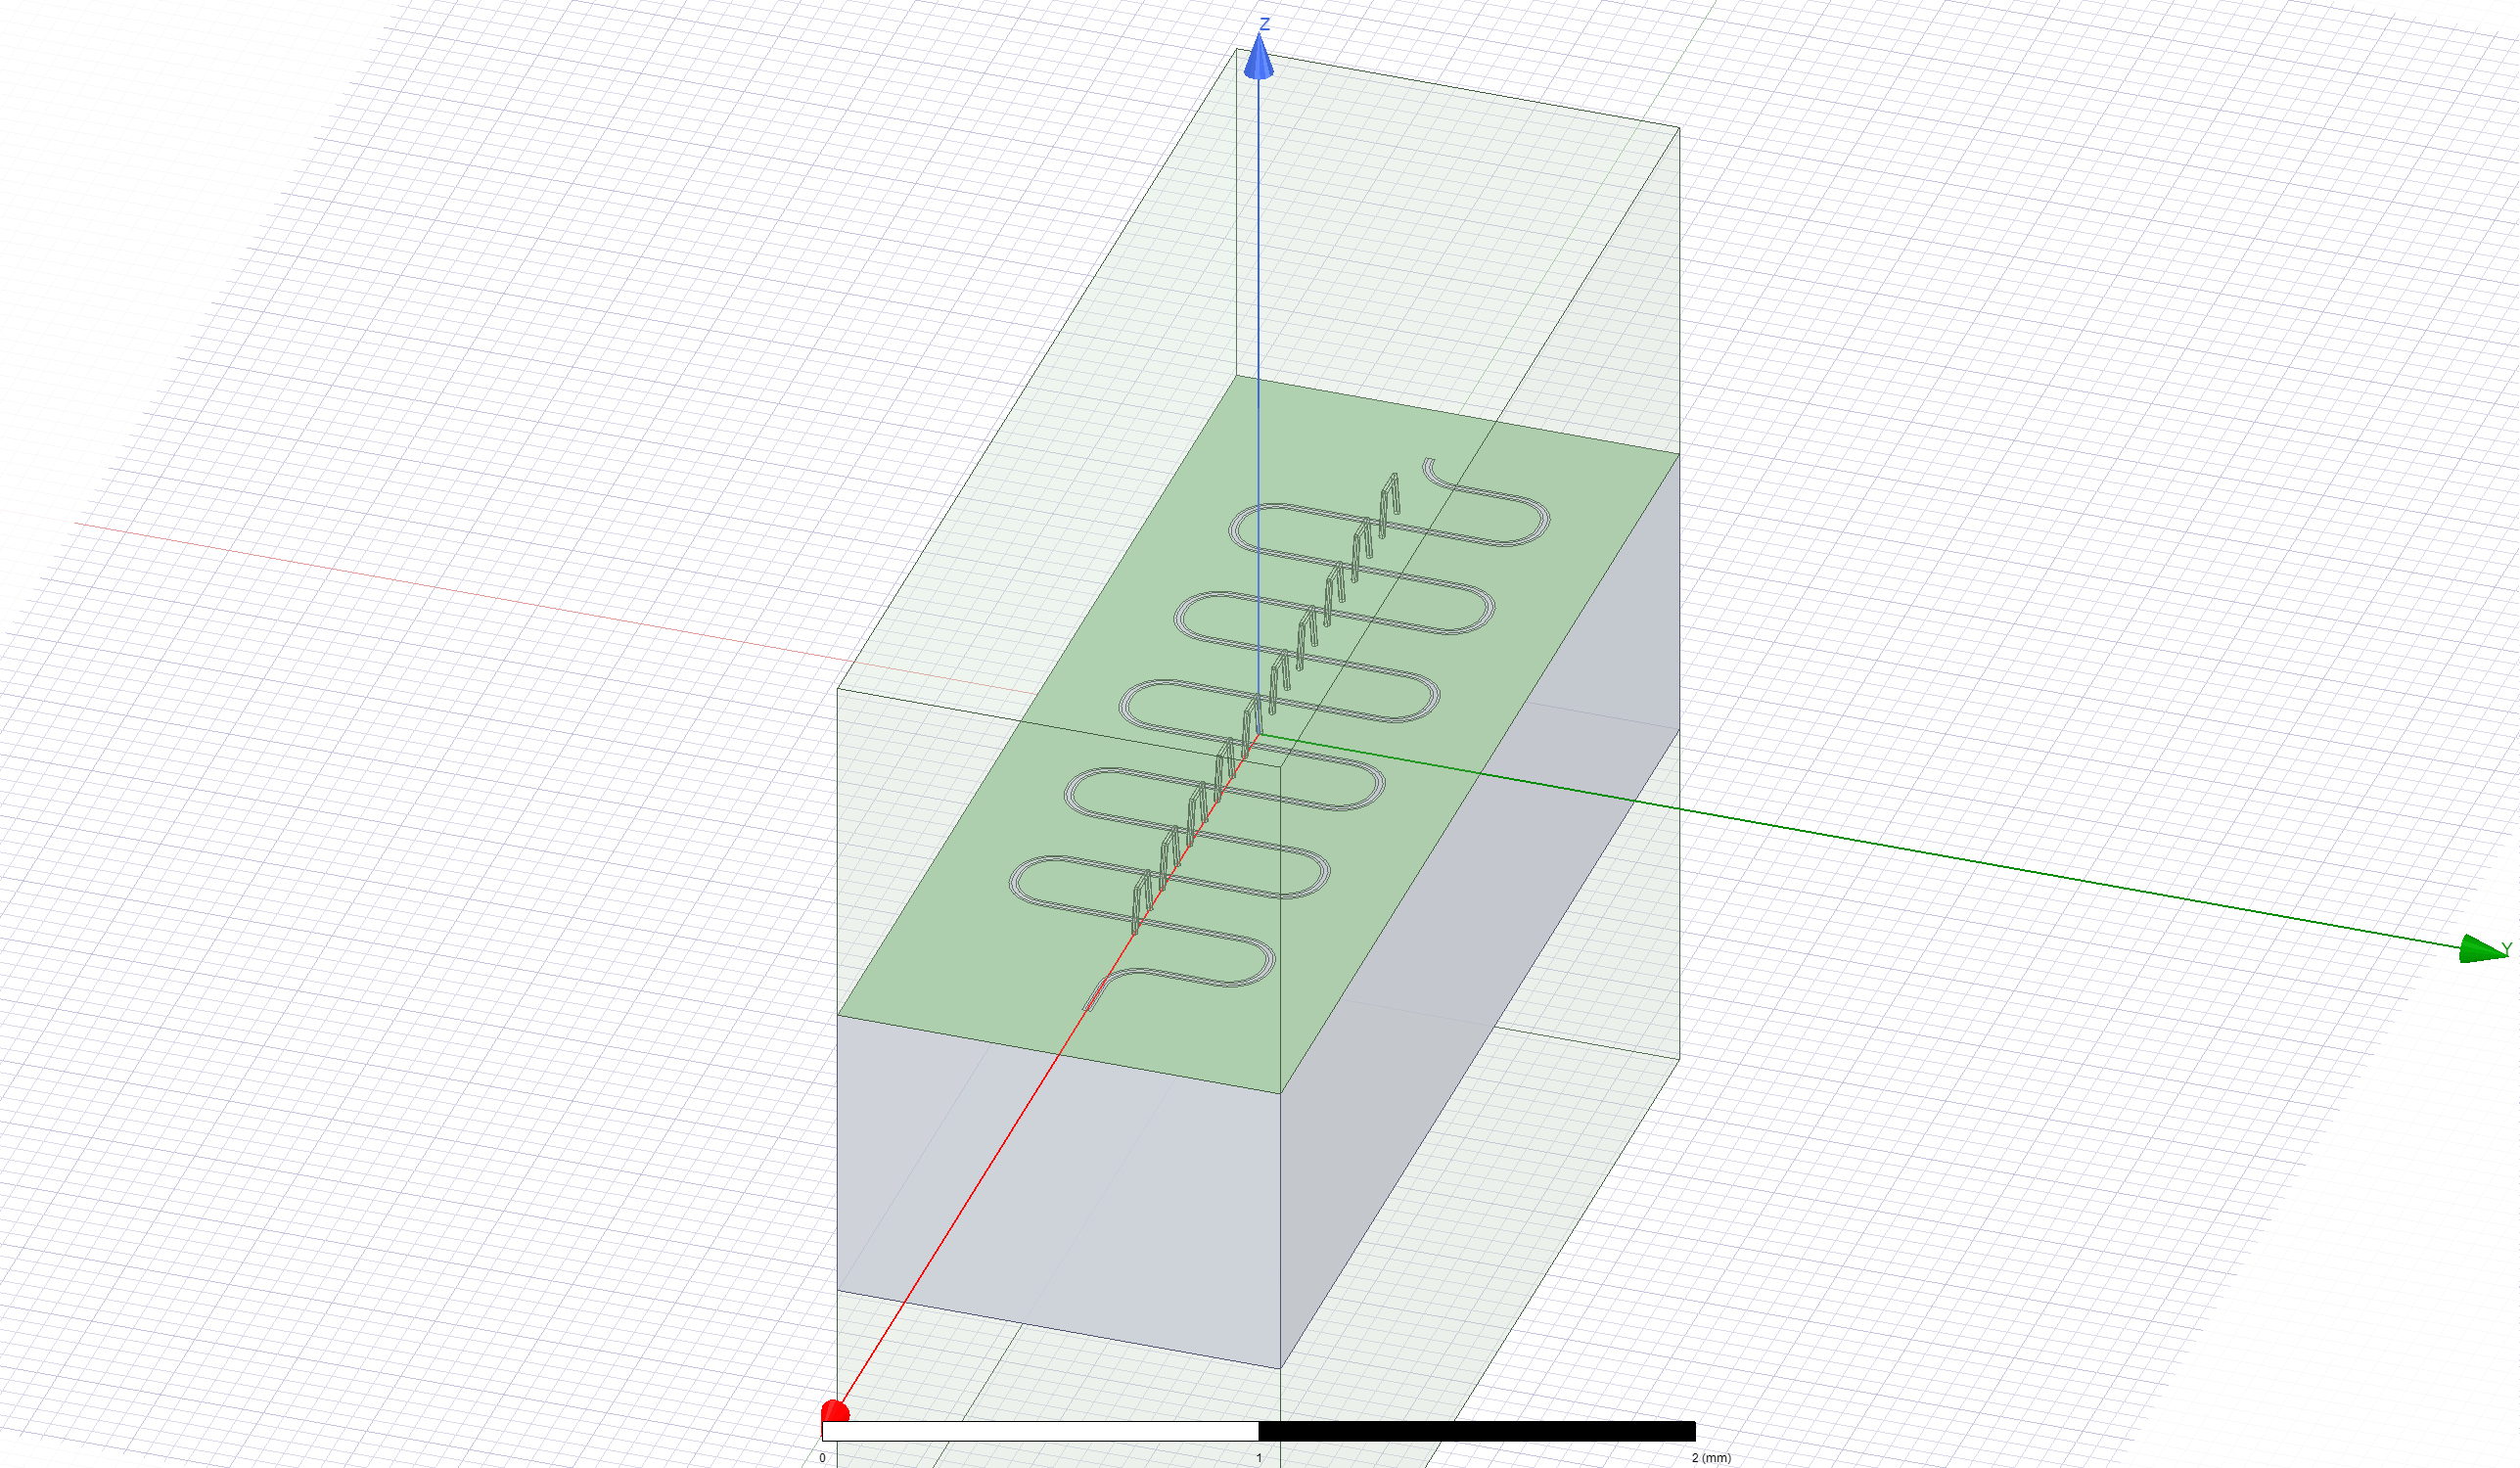

WindowsPath('C:/workspace/qiskit-metal/docs/tut/4-Analysis/ansys.png')

In [16]:
hfss.render_design(['short_to_ground','readout', 'open_to_ground'], [])
hfss.save_screenshot()

now re-execute the analysis. We will skip the design variable setup since they are still in memory.

In [17]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 20
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

# Next 2 lines are counterinuitive, since there is no junction in this resonator.
# However, these are necessary to make pyEPR work correctly. Please do note delete
hfss.pinfo.design.set_variable('Lj', '10 nH')
hfss.pinfo.design.set_variable('Cj', '0 fF')

setup.analyze()

INFO 09:22AM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 1
Number of simulation passes              = 20
Convergence freq max delta percent diff  = 0.1



In [18]:
eig_res.sim.convergence_t, eig_res.sim.convergence_f, _ = hfss.get_convergences()
eig_res.sim.plot_convergences()

09:24AM 46s INFO [get_f_convergence]: Saved convergences to C:\workspace\qiskit-metal\docs\tut\4-Analysis\hfss_eig_f_convergence.csv


From the above analyses we observe that for a total length of 6 mm for the resonator, the Eigen Frequency was close to 4.9 GHz. However, for a total length of 9 mm, this frequency is close to 3.3 GHz. Similar analysis can be performed by the user for matching a particular frequency of interest.

#### Plot the EM field for inspection
Display the Ansys modeler window and plot the E-field on the chip's surface.

09:24AM 48s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


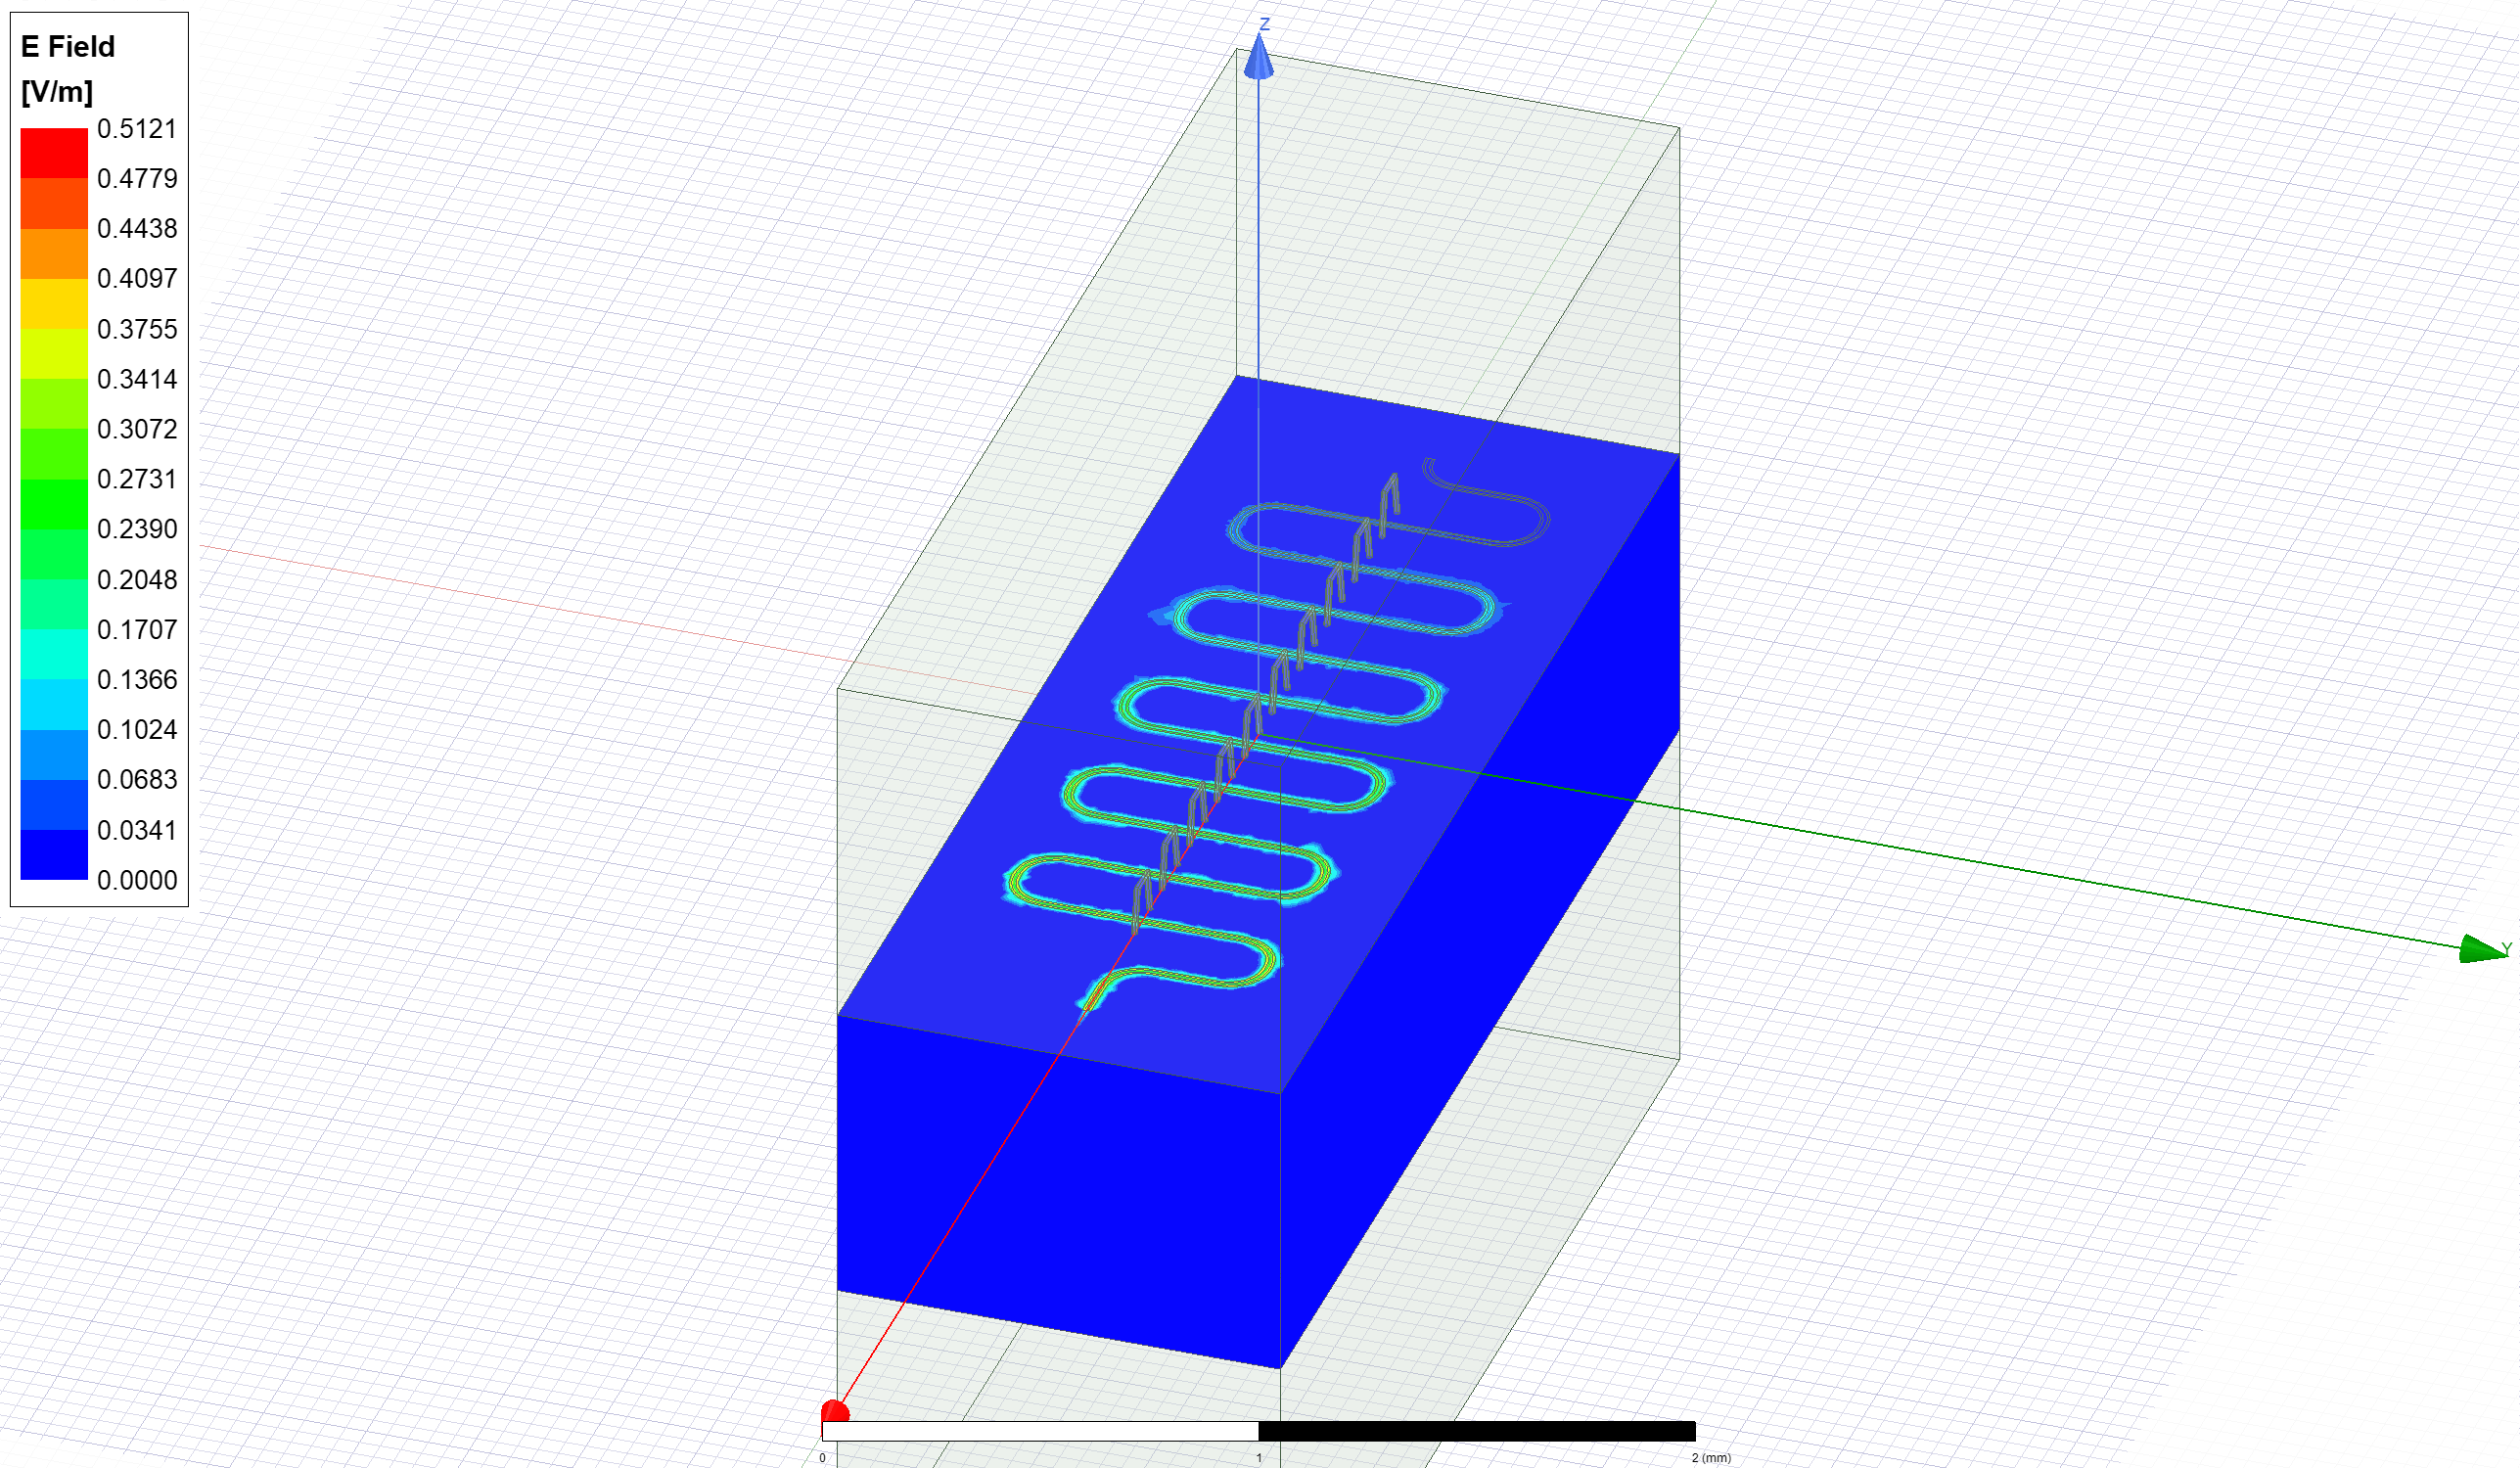

WindowsPath('C:/workspace/qiskit-metal/docs/tut/4-Analysis/ansys.png')

In [19]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

Delete the newly created E-field plot to prepare for the next phase.

In [20]:
hfss.plot_ansys_delete(['Mag_E1'])

09:24AM 52s WARNING [plot_ansys_delete]: This method is deprecated. Change your scripts to use clear_fields()


### EPR Analysis
In the `suggested` (tutorial 4.2) flow, we would now prepare the setup using `eig_res.setup` and run the analysis with `eig_res.run_epr()`. Notice that this method requires previous set of the `eig_res` variables `convergence_t` and `convergence_f` like we did a thee cells earlier.

However we here exemplify the advanced approach, which is Ansys-specific since it uses the pyEPR module methods directly.
#### Execute the energy distribution analysis

First initialize epr for non-junction analysis. This will set the ground plain to 'main'.

In [21]:
eig_res.epr_start(no_junctions=True)

Design "Readout_1" info:
	# eigenmodes    1
	# variations    1


{'junctions': {}, 'dissipatives': {'dielectrics_bulk': ['main']}}

Execute microwave analysis on eigenmode solutions.

In [22]:
eprd = hfss.epr_distributed_analysis

Find the electric and magnetic energy stored in the substrate and the system.

In [23]:
ℰ_elec = eprd.calc_energy_electric()
ℰ_elec_substrate = eprd.calc_energy_electric(None, 'main')
ℰ_mag = eprd.calc_energy_magnetic()

print(f"""
ℰ_elec_all       = {ℰ_elec}
ℰ_elec_substrate = {ℰ_elec_substrate}
EPR of substrate = {ℰ_elec_substrate / ℰ_elec * 100 :.1f}%

ℰ_mag    = {ℰ_mag}
""")


ℰ_elec_all       = 4.15624846946662e-24
ℰ_elec_substrate = 3.78016656502688e-24
EPR of substrate = 91.0%

ℰ_mag    = 4.15625817565646e-24



Release Ansys session

In [24]:
eig_res.sim.close()

(optional) close the GUI.

In [25]:
# gui.main_window.close()